In [8]:
!pip install git+https://github.com/jacobgil/pytorch-grad-cam.git

  Cloning https://github.com/jacobgil/pytorch-grad-cam.git to /tmp/pip-req-build-rc1cn8af
  Running command git clone --filter=blob:none --quiet https://github.com/jacobgil/pytorch-grad-cam.git /tmp/pip-req-build-rc1cn8af
  Resolved https://github.com/jacobgil/pytorch-grad-cam.git to commit 781dbc0d16ffa95b6d18b96b7b829840a82d93d1
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached numpy-2.2.6-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
INFO: pip is looking at multiple versions of scipy to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 2.3 MB/s eta 0:00:00
Using cached numpy-2.2.6-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (16.8 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.9/35.9 MB 54.7 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall:

In [9]:
!pip uninstall -y scipy scikit-learn numpy
!pip install scipy==1.11.4 scikit-learn==1.4.2 --quiet

Found existing installation: scipy 1.16.2
Uninstalling scipy-1.16.2:
  Successfully uninstalled scipy-1.16.2
Found existing installation: scikit-learn 1.4.2
Uninstalling scikit-learn-1.4.2:
  Successfully uninstalled scikit-learn-1.4.2
Found existing installation: numpy 2.2.6
Uninstalling numpy-2.2.6:
  Successfully uninstalled numpy-2.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
datasets 4.1.1 requires pyarrow>=21.0.0, but you have pyarrow 19.0.1 which is incompatible.
onnx 1.18.0 requires protobuf>=4.25.1, but you have protobuf 3.20.3 which is incompatible.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
google-colab 1.0.0 requires google-auth==2.38.0, but you have google-auth 2.40.3 which is incompatible.
google-cola

In [10]:
!pip install numpy==1.26.4 --force-reinstall

  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
datasets 4.1.1 requires pyarrow>=21.0.0, but you have pyarrow 19.0.1 which is incompatible.
onnx 1.18.0 requires protobuf>=4.25.1, but you have protobuf 3.20.3 which is incompatible.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
google-colab 1.0.0 requires google-auth==2.38.0, but you have google-auth 2.40.3 which is incompatible.
goo

Found 6 images. Missing: 0
Processing: Autistic.112.jpg


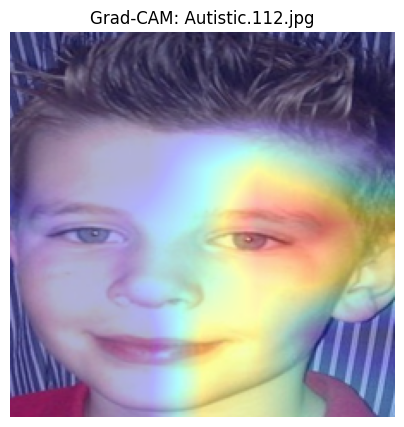

Processing: Autistic.30.jpg


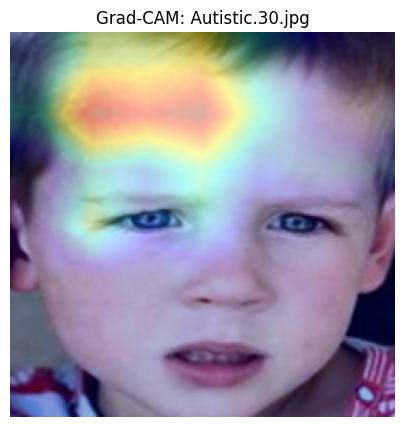

Processing: Autistic.81.jpg


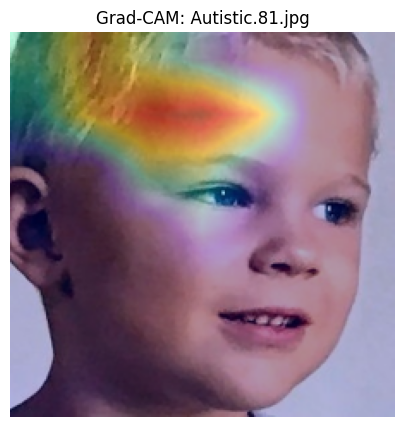

Processing: Non_Autistic.74.jpg


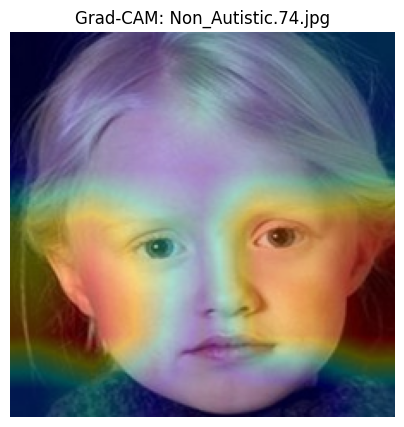

Processing: Non_Autistic.63.jpg


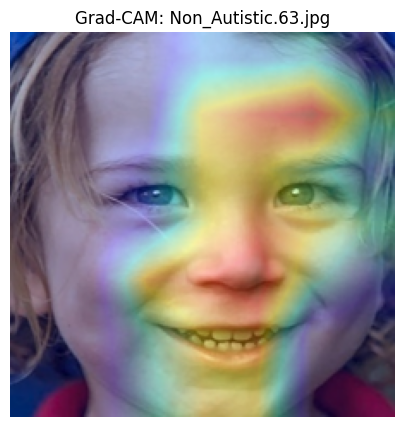

Processing: Non_Autistic.55.jpg


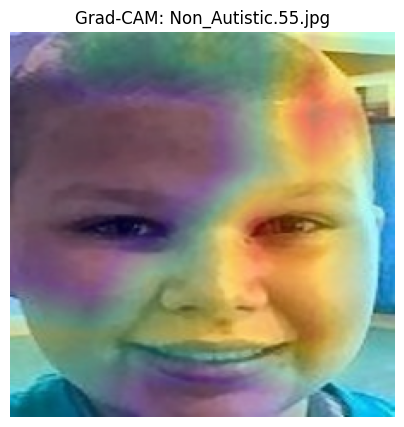

In [11]:
# gradcam_subset.py
# -----------------------------------------------------------
# Imports
import os, torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms, models
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image

# -----------------------------------------------------------
# Configuration
DATA_PATH = "/kaggle/input/autism-image-data/AutismDataset"
TEST_PATH = os.path.join(DATA_PATH, "test")

CKPT_PATH = "/kaggle/input/autism-spectrum-detection-from-kaggle-zenodo/Model results/Model results/best_densenet201_autism.pth"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Explicit subset of test images
TARGET_FILES = [
    "Autistic.112.jpg",
    "Autistic.30.jpg",
    "Autistic.81.jpg",
    "Non_Autistic.74.jpg",
    "Non_Autistic.63.jpg",
    "Non_Autistic.55.jpg",
]

# -----------------------------------------------------------
# Validate selected images
selected_image_paths = []
missing = []
for fname in TARGET_FILES:
    candidate = os.path.join(TEST_PATH, fname)
    if os.path.exists(candidate):
        selected_image_paths.append(candidate)
    else:
        missing.append(fname)

print(f"Found {len(selected_image_paths)} images. Missing: {len(missing)}")
if missing:
    print("Missing files:", missing)

# -----------------------------------------------------------
# Preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# -----------------------------------------------------------
# Model Definition
import torch.nn as nn

def create_densenet201_model(num_classes=2, pretrained=False, dropout_rate=0.5):
    model = models.densenet201(pretrained=pretrained)
    num_features = model.classifier.in_features
    model.classifier = nn.Sequential(
        nn.Dropout(dropout_rate),
        nn.Linear(num_features, 512),
        nn.BatchNorm1d(512),
        nn.ReLU(inplace=True),
        nn.Dropout(dropout_rate / 2),
        nn.Linear(512, 256),
        nn.BatchNorm1d(256),
        nn.ReLU(inplace=True),
        nn.Dropout(dropout_rate / 4),
        nn.Linear(256, num_classes)
    )
    return model

# -----------------------------------------------------------
# Load Model
model = create_densenet201_model(num_classes=2, pretrained=False).to(DEVICE)
model.load_state_dict(torch.load(CKPT_PATH, map_location=DEVICE))
model.eval()

# -----------------------------------------------------------
# Grad-CAM Setup
target_layers = [model.features.denseblock4.denselayer16.conv2]
cam = GradCAM(model=model, target_layers=target_layers)

# -----------------------------------------------------------
# Visualization Loop
for img_path in selected_image_paths:
    print(f"Processing: {os.path.basename(img_path)}")

    # Load image
    img_pil = Image.open(img_path).convert("RGB")
    rgb = np.array(img_pil.resize((224, 224))) / 255.0
    rgb = np.clip(rgb, 0, 1)

    # Preprocess for model
    input_tensor = transform(img_pil).unsqueeze(0).to(DEVICE)

    # Run Grad-CAM
    grayscale_cam = cam(input_tensor=input_tensor)[0]  # first image only

    # Overlay CAM
    visualization = show_cam_on_image(rgb.astype(np.float32),
                                      grayscale_cam,
                                      use_rgb=True,
                                      image_weight=0.7)

    # Plot
    plt.figure(figsize=(5, 5))
    plt.imshow(visualization)
    plt.title(f"Grad-CAM: {os.path.basename(img_path)}")
    plt.axis("off")
    plt.show()

🎯 Finding target layer for Xception...
✅ Found target layer: features.bn4
🔍 Layer type: BatchNorm2d
BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Processing: Autistic.112.jpg


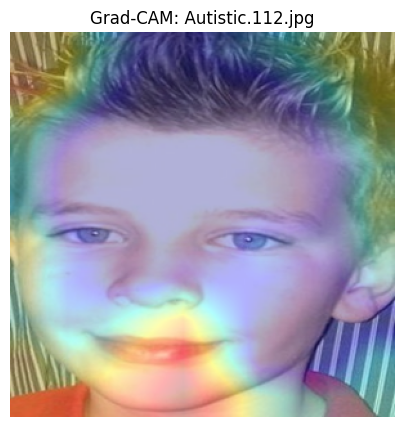

Processing: Autistic.30.jpg


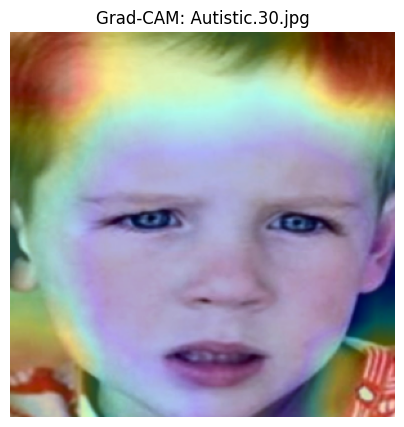

Processing: Autistic.81.jpg


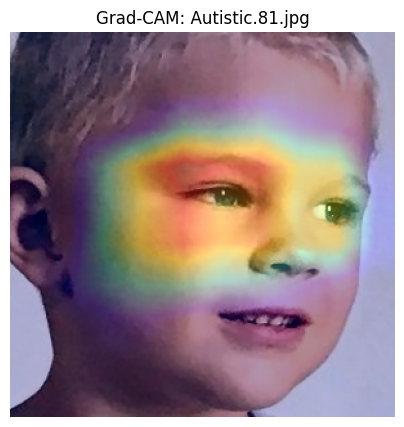

Processing: Non_Autistic.74.jpg


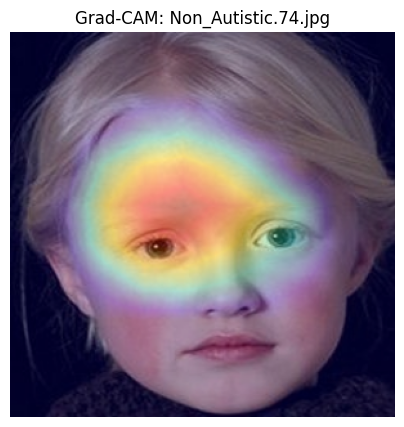

Processing: Non_Autistic.63.jpg


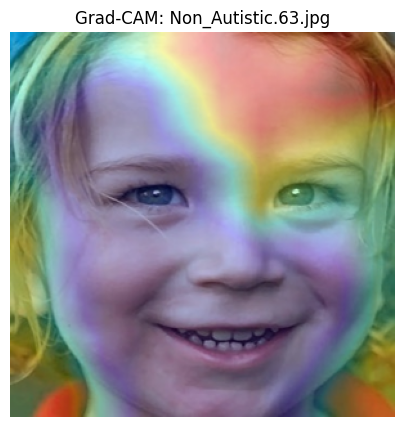

Processing: Non_Autistic.55.jpg


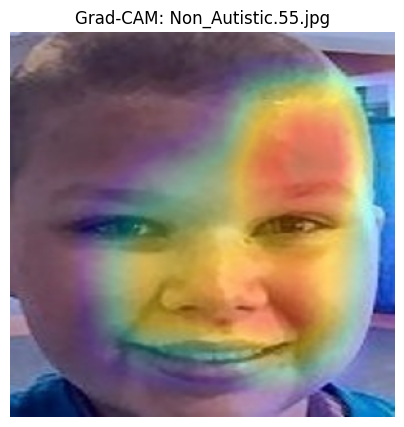

In [15]:
CKPT_PATH_2 = "/kaggle/input/autism-spectrum-detection-from-kaggle-zenodo/Model results/Model results/best_xception_autism.pth"

# -----------------------------------------------------------
# Preprocessing
transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# -----------------------------------------------------------
# Model Definition
import torch.nn as nn
import timm

def create_xception_model(num_classes=2, pretrained=True, dropout_rate=0.5):
    """
    Create Xception model using timm library
    
    Args:
        num_classes (int): Number of output classes
        pretrained (bool): Whether to use pretrained weights
        dropout_rate (float): Dropout rate for regularization
    """
    # Load pretrained Xception from timm
    model = timm.create_model('xception', pretrained=pretrained, num_classes=0)  # num_classes=0 removes head
    
    # Get the number of features
    num_features = model.num_features
    
    # Add custom classification head
    model.head = nn.Sequential(
        nn.AdaptiveAvgPool2d((1, 1)),
        nn.Flatten(),
        nn.Dropout(dropout_rate),
        nn.Linear(num_features, 512),
        nn.BatchNorm1d(512),
        nn.ReLU(inplace=True),
        nn.Dropout(dropout_rate/2),
        nn.Linear(512, 256),
        nn.BatchNorm1d(256),
        nn.ReLU(inplace=True),
        nn.Dropout(dropout_rate/4),
        nn.Linear(256, num_classes)
    )
    
    # Wrap in a custom module to handle forward pass
    class XceptionWrapper(nn.Module):
        def __init__(self, base_model):
            super(XceptionWrapper, self).__init__()
            self.features = base_model
            self.head = base_model.head
            
        def forward(self, x):
            # Extract features (without head)
            x = self.features.forward_features(x)
            # Apply custom head
            x = self.head(x)
            return x
    
    return XceptionWrapper(model)

# -----------------------------------------------------------
# Load Model
model = create_xception_model(num_classes=2, pretrained=False).to(DEVICE)
model.load_state_dict(torch.load(CKPT_PATH_2, map_location=DEVICE))
model.eval()

def get_xception_target_layer(model, model_variant='xception'):
    """
    Get the target layer for GradCAM - ONLY for xception
    """
    print(f"🎯 Finding target layer for Xception...")
    
    target_layer = None
    
    try:
        # For timm xception models, find the last convolutional layer
        for name, module in model.named_modules():
            if isinstance(module, (nn.Conv2d, nn.BatchNorm2d)):
                target_layer = module
                last_conv_name = name
        
        if target_layer is not None:
            print(f"✅ Found target layer: {last_conv_name}")
            print(f"🔍 Layer type: {type(target_layer).__name__}")
            if hasattr(target_layer, 'out_channels'):
                print(f"📊 Output channels: {target_layer.out_channels}")
        else:
            print("❌ No suitable target layer found")
    
    except Exception as e:
        print(f"❌ Error finding target layer: {e}")
        target_layer = None
    
    return target_layer

target_layer = get_xception_target_layer(model)
print(target_layer)

# -----------------------------------------------------------
# Grad-CAM Setup
target_layers = [target_layer]
cam = GradCAM(model=model, target_layers=target_layers)

# -----------------------------------------------------------
# Visualization Loop
for img_path in selected_image_paths:
    print(f"Processing: {os.path.basename(img_path)}")

    # Load image
    img_pil = Image.open(img_path).convert("RGB")
    rgb = np.array(img_pil.resize((299, 299))) / 255.0
    rgb = np.clip(rgb, 0, 1)

    # Preprocess for model
    input_tensor = transform(img_pil).unsqueeze(0).to(DEVICE)

    # Run Grad-CAM
    grayscale_cam = cam(input_tensor=input_tensor)[0]  # first image only

    # Overlay CAM
    visualization = show_cam_on_image(rgb.astype(np.float32),
                                      grayscale_cam,
                                      use_rgb=True,
                                      image_weight=0.7)

    # Plot
    plt.figure(figsize=(5, 5))
    plt.imshow(visualization)
    plt.title(f"Grad-CAM: {os.path.basename(img_path)}")
    plt.axis("off")
    plt.show()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


🎯 Finding target layer for EfficientNet-B0...
✅ Found target layer: features.8.1
🔍 Layer type: BatchNorm2d
BatchNorm2d(1280, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Processing: Autistic.112.jpg


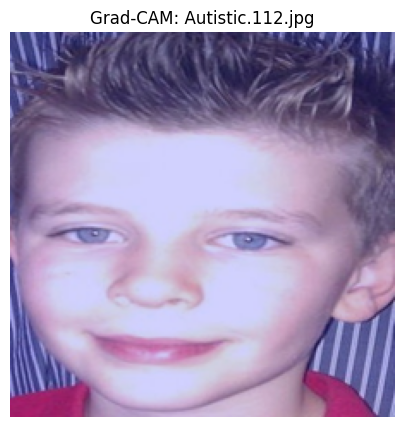

Processing: Autistic.30.jpg


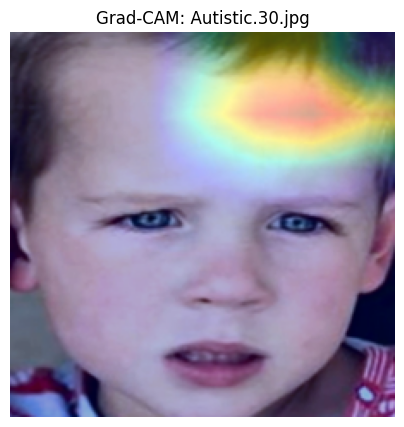

Processing: Autistic.81.jpg


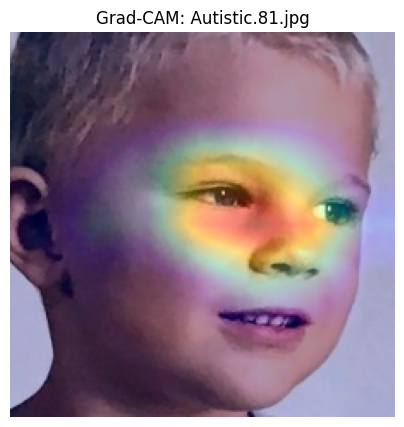

Processing: Non_Autistic.74.jpg


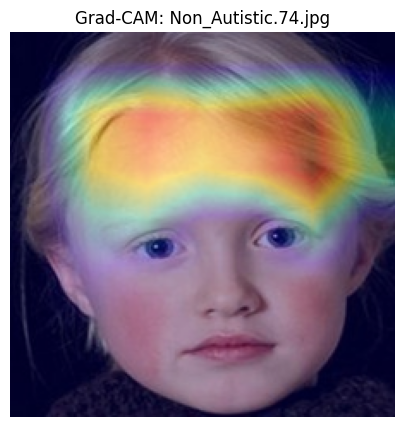

Processing: Non_Autistic.63.jpg


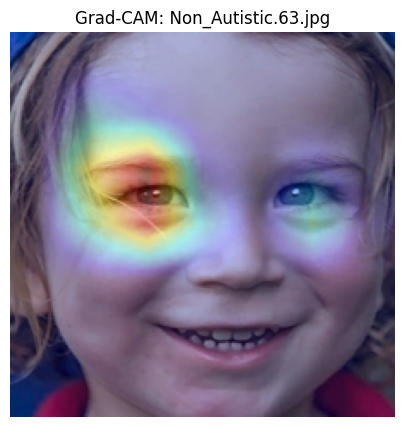

Processing: Non_Autistic.55.jpg


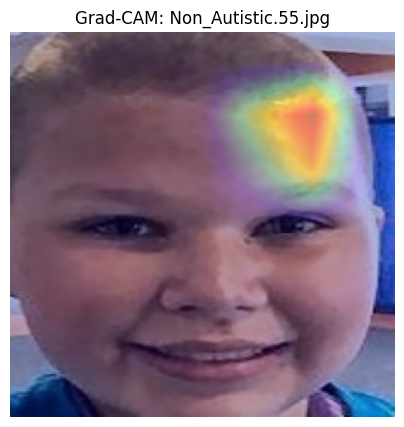

In [16]:
CKPT_PATH_3 = "/kaggle/input/autism-spectrum-detection-from-kaggle-zenodo/Model results/Model results/best_effnet-b1.pth"

# -----------------------------------------------------------
# Preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# -----------------------------------------------------------
# Model Definition
import torch.nn as nn

def create_efficientnet_model(architecture='b0', num_classes=2, pretrained=True):
    """Create EfficientNet model for binary classification"""
    if architecture == 'b0':
        model = models.efficientnet_b0(pretrained=pretrained)
    elif architecture == 'b1':
        model = models.efficientnet_b1(pretrained=pretrained)
    elif architecture == 'b2':
        model = models.efficientnet_b2(pretrained=pretrained)
    else:
        raise ValueError("Architecture must be 'b0', 'b1', or 'b2'")
    
    # Modify classifier
    num_features = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(num_features, num_classes)
    
    return model

# -----------------------------------------------------------
# Load Model
model = create_efficientnet_model(architecture='b1', num_classes=2, pretrained=False).to(DEVICE)
model.load_state_dict(torch.load(CKPT_PATH_3, map_location=DEVICE))
model.eval()

def get_efficientnet_b1_target_layer(model):
    """
    Get the target layer for GradCAM - for EfficientNet-B1
    """
    print(f"🎯 Finding target layer for EfficientNet-B0...")
    
    target_layer = None
    
    try:
        # For EfficientNet-B0, find the last convolutional layer in features
        for name, module in model.named_modules():
            if isinstance(module, (nn.Conv2d, nn.BatchNorm2d)):
                target_layer = module
                last_conv_name = name
        
        if target_layer is not None:
            print(f"✅ Found target layer: {last_conv_name}")
            print(f"🔍 Layer type: {type(target_layer).__name__}")
            if hasattr(target_layer, 'out_channels'):
                print(f"📊 Output channels: {target_layer.out_channels}")
        else:
            print("❌ No suitable target layer found")
    
    except Exception as e:
        print(f"❌ Error finding target layer: {e}")
        target_layer = None
    
    return target_layer

target_layer = get_efficientnet_b1_target_layer(model)
print(target_layer)

# -----------------------------------------------------------
# Grad-CAM Setup
target_layers = [target_layer]
cam = GradCAM(model=model, target_layers=target_layers)

# -----------------------------------------------------------
# Visualization Loop
for img_path in selected_image_paths:
    print(f"Processing: {os.path.basename(img_path)}")

    # Load image
    img_pil = Image.open(img_path).convert("RGB")
    rgb = np.array(img_pil.resize((224, 224))) / 255.0
    rgb = np.clip(rgb, 0, 1)

    # Preprocess for model
    input_tensor = transform(img_pil).unsqueeze(0).to(DEVICE)

    # Run Grad-CAM
    grayscale_cam = cam(input_tensor=input_tensor)[0]  # first image only

    # Overlay CAM
    visualization = show_cam_on_image(rgb.astype(np.float32),
                                      grayscale_cam,
                                      use_rgb=True,
                                      image_weight=0.7)

    # Plot
    plt.figure(figsize=(5, 5))
    plt.imshow(visualization)
    plt.title(f"Grad-CAM: {os.path.basename(img_path)}")
    plt.axis("off")
    plt.show()

In [18]:
!pip install facenet_pytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 35.2 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 87.1 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.6/755.6 MB 2.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 48.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 50.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 32.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 3.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 21.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 12.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [19]:
!pip install --upgrade pillow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 56.1 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: pillow
    Found existing installation: pillow 10.2.0
    Uninstalling pillow-10.2.0:
      Successfully uninstalled pillow-10.2.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
facenet-pytorch 2.6.0 requires Pillow<10.3.0,>=10.2.0, but you have pillow 12.0.0 which is incompatible.
dopamine-rl 4.1.2 requires gymnasium>=1.0.0, but you have gymnasium 0.29.0 which is incompatible.
bigframes 2.12.0 requires google-cloud-bigquery[bqstorage,pandas]>=3.31.0, but you have google-cloud-bigquery 3.25.0 which is incompatible.
bigframes 2.12.0 requires rich<14,>=12.4.4, but you have rich 14.1.0 which is incompatible.
gradio 5.38.1 requires pillow<12.0,>=8.0, but you ha

Conv2d(384, 1792, kernel_size=(1, 1), stride=(1, 1))
Processing: Autistic.112.jpg


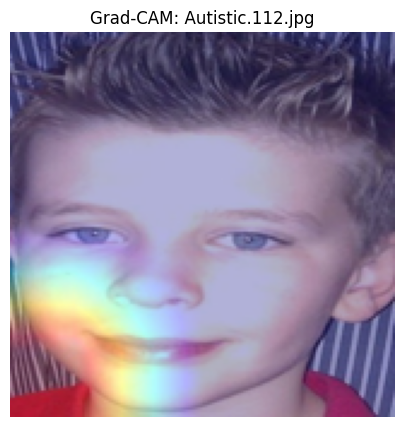

Processing: Autistic.30.jpg


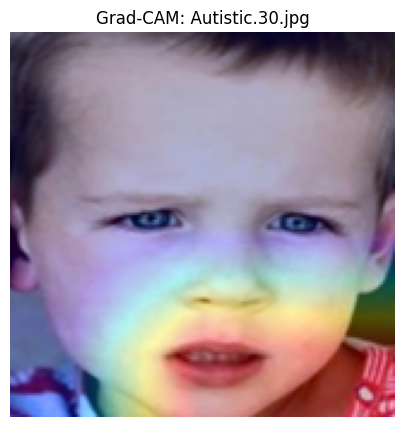

Processing: Autistic.81.jpg


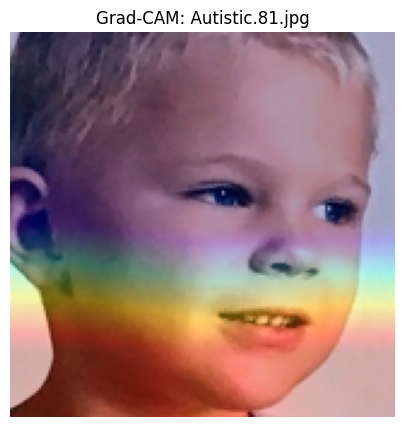

Processing: Non_Autistic.74.jpg


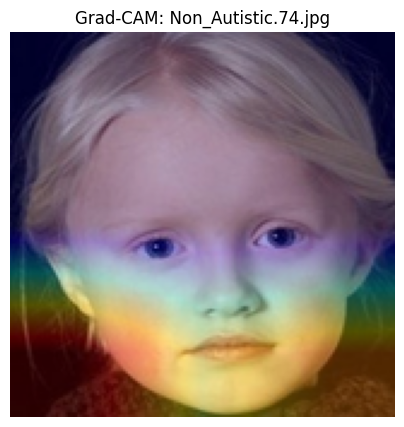

Processing: Non_Autistic.63.jpg


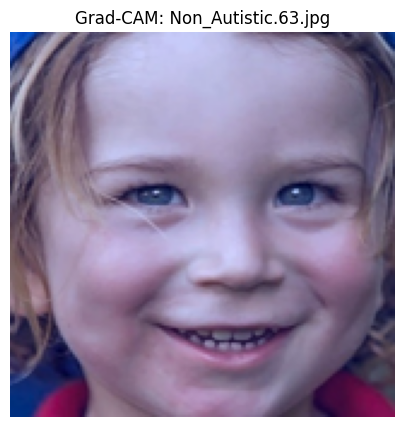

Processing: Non_Autistic.55.jpg


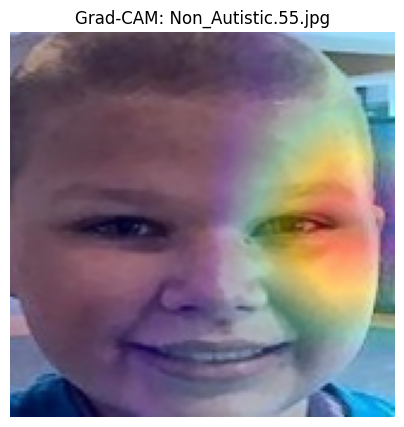

In [23]:
CKPT_PATH_4 = "/kaggle/input/autism-spectrum-detection-from-kaggle-zenodo/Model results/Model results/best_facenet_autism.pth"

# -----------------------------------------------------------
# Preprocessing
transform = transforms.Compose([
    transforms.Resize((160, 160)),  # Standard face recognition input size
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Face-specific normalization
])

# -----------------------------------------------------------
# Model Definition
import torch.nn as nn
from facenet_pytorch import InceptionResnetV1

def create_facenet_model(num_classes=2, pretrained=True, embedding_size=512):
    """Create FaceNet model using InceptionResnetV1"""
    
    class FaceNetClassifier(nn.Module):
        def __init__(self, num_classes, pretrained=True, embedding_size=512):
            super(FaceNetClassifier, self).__init__()
            # Load pretrained FaceNet model
            self.facenet = InceptionResnetV1(pretrained='vggface2' if pretrained else None, 
                                           classify=False, 
                                           num_classes=None)
            
            # Add classification head
            self.classifier = nn.Sequential(
                nn.Dropout(0.5),
                nn.Linear(embedding_size, 256),
                nn.ReLU(),
                nn.Dropout(0.3),
                nn.Linear(256, num_classes)
            )
            
        def forward(self, x):
            # Get embeddings from FaceNet
            embeddings = self.facenet(x)
            # Classify using our head
            output = self.classifier(embeddings)
            return output
    
    return FaceNetClassifier(num_classes, pretrained, embedding_size)

# -----------------------------------------------------------
# Load Model
model = create_facenet_model(num_classes=2, pretrained=True).to(DEVICE)
model.load_state_dict(torch.load(CKPT_PATH_4, map_location=DEVICE))
model.eval()

def get_target_layer_for_facial_model(model, model_name):
    """Get appropriate target layer for GradCAM based on FaceNet model architecture"""
    
    try:
        if 'facenet' in model_name.lower():
            # FaceNet: Try to find the last conv layer in InceptionResnetV1
            try:
                return model.facenet.mixed_7a.branch1x1  # Last conv layer before pooling
            except AttributeError:
                # Fallback: find last conv layer
                for name, module in reversed(list(model.facenet.named_modules())):
                    if isinstance(module, nn.Conv2d):
                        return module
        
        else:
            # Fallback: try to find last convolutional layer
            for name, module in reversed(list(model.named_modules())):
                if isinstance(module, nn.Conv2d):
                    return module
            return None
    except Exception as e:
        print(f"Warning: Error finding target layer for {model_name}: {e}")
        # Ultimate fallback
        for name, module in reversed(list(model.named_modules())):
            if isinstance(module, nn.Conv2d):
                return module
        return None

target_layer = get_target_layer_for_facial_model(model,'facenet')
print(target_layer)

# -----------------------------------------------------------
# Grad-CAM Setup
target_layers = [target_layer]
cam = GradCAM(model=model, target_layers=target_layers)

# -----------------------------------------------------------
# Visualization Loop
for img_path in selected_image_paths:
    print(f"Processing: {os.path.basename(img_path)}")

    # Load image
    img_pil = Image.open(img_path).convert("RGB")
    rgb = np.array(img_pil.resize((160, 160))) / 255.0
    rgb = np.clip(rgb, 0, 1)

    # Preprocess for model
    input_tensor = transform(img_pil).unsqueeze(0).to(DEVICE)

    # Run Grad-CAM
    grayscale_cam = cam(input_tensor=input_tensor)[0]  # first image only

    # Overlay CAM
    visualization = show_cam_on_image(rgb.astype(np.float32),
                                      grayscale_cam,
                                      use_rgb=True,
                                      image_weight=0.7)

    # Plot
    plt.figure(figsize=(5, 5))
    plt.imshow(visualization)
    plt.title(f"Grad-CAM: {os.path.basename(img_path)}")
    plt.axis("off")
    plt.show()

🎯 Finding target layer for Mobilenet_v3_large...
✅ Found target layer: features.16.1
🔍 Layer type: BatchNorm2d
BatchNorm2d(960, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
Processing: Autistic.112.jpg


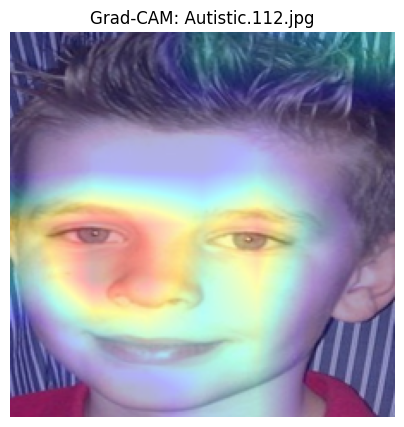

Processing: Autistic.30.jpg


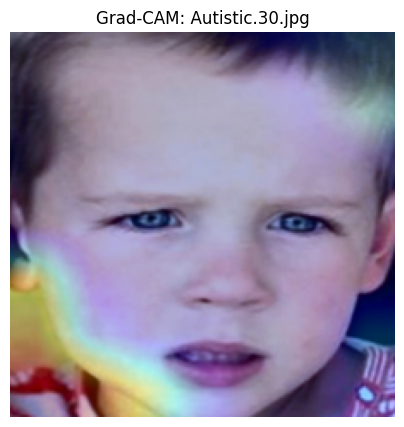

Processing: Autistic.81.jpg


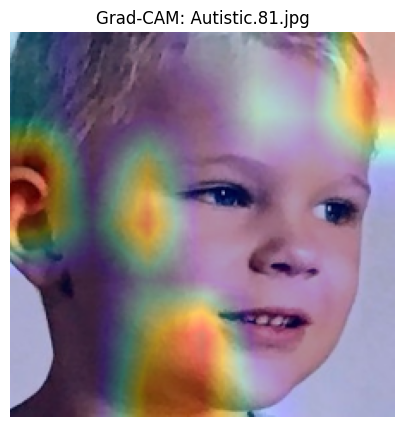

Processing: Non_Autistic.74.jpg


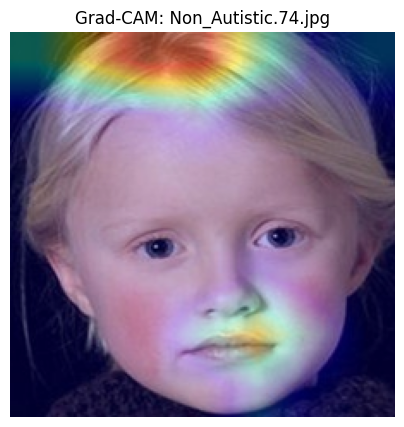

Processing: Non_Autistic.63.jpg


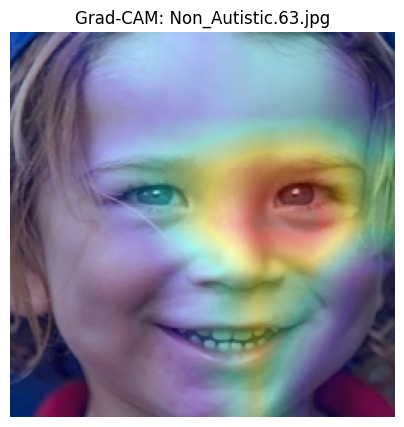

Processing: Non_Autistic.55.jpg


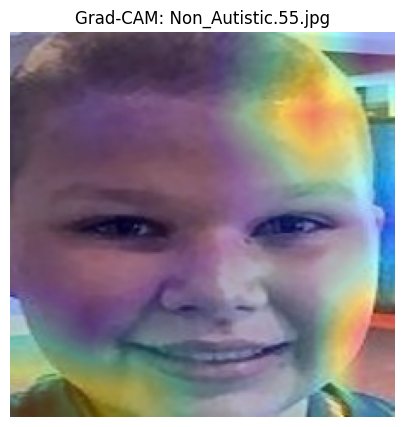

In [25]:
CKPT_PATH_5 = "/kaggle/input/autism-spectrum-detection-from-kaggle-zenodo/Model results/Model results/best_mobilenet_v3_large.pth"

# -----------------------------------------------------------
# Preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) 
])

# -----------------------------------------------------------
# Model Definition
import torch.nn as nn

def create_mobilenet_model(version='v2', num_classes=2, pretrained=True):
    """Create MobileNet model (v2 or v3) for binary classification"""
    if version == 'v2':
        model = models.mobilenet_v2(pretrained=pretrained)
        # Modify classifier
        num_features = model.classifier[1].in_features
        model.classifier[1] = nn.Linear(num_features, num_classes)
    elif version == 'v3_large':
        model = models.mobilenet_v3_large(pretrained=pretrained)
        # Modify classifier
        num_features = model.classifier[3].in_features
        model.classifier[3] = nn.Linear(num_features, num_classes)
    elif version == 'v3_small':
        model = models.mobilenet_v3_small(pretrained=pretrained)
        # Modify classifier
        num_features = model.classifier[3].in_features
        model.classifier[3] = nn.Linear(num_features, num_classes)
    else:
        raise ValueError("Version must be 'v2', 'v3_large', or 'v3_small'")
    
    return model

# -----------------------------------------------------------
# Load Model
model = create_mobilenet_model(version="v3_large",num_classes=2, pretrained=False).to(DEVICE)
model.load_state_dict(torch.load(CKPT_PATH_5, map_location=DEVICE))
model.eval()

def get_mobilenet_v3_large_target_layer(model):
    """
    Get the target layer for GradCAM - for EfficientNet-B1
    """
    print(f"🎯 Finding target layer for Mobilenet_v3_large...")
    
    target_layer = None
    
    try:
        # For Mobilenet V3, find the last convolutional layer in features
        for name, module in model.named_modules():
            if isinstance(module, (nn.Conv2d, nn.BatchNorm2d)):
                target_layer = module
                last_conv_name = name
        
        if target_layer is not None:
            print(f"✅ Found target layer: {last_conv_name}")
            print(f"🔍 Layer type: {type(target_layer).__name__}")
            if hasattr(target_layer, 'out_channels'):
                print(f"📊 Output channels: {target_layer.out_channels}")
        else:
            print("❌ No suitable target layer found")
    
    except Exception as e:
        print(f"❌ Error finding target layer: {e}")
        target_layer = None
    
    return target_layer

target_layer = get_mobilenet_v3_large_target_layer(model)
print(target_layer)

# -----------------------------------------------------------
# Grad-CAM Setup
target_layers = [target_layer]
cam = GradCAM(model=model, target_layers=target_layers)

# -----------------------------------------------------------
# Visualization Loop
for img_path in selected_image_paths:
    print(f"Processing: {os.path.basename(img_path)}")

    # Load image
    img_pil = Image.open(img_path).convert("RGB")
    rgb = np.array(img_pil.resize((224, 224))) / 255.0
    rgb = np.clip(rgb, 0, 1)

    # Preprocess for model
    input_tensor = transform(img_pil).unsqueeze(0).to(DEVICE)

    # Run Grad-CAM
    grayscale_cam = cam(input_tensor=input_tensor)[0]  # first image only

    # Overlay CAM
    visualization = show_cam_on_image(rgb.astype(np.float32),
                                      grayscale_cam,
                                      use_rgb=True,
                                      image_weight=0.7)

    # Plot
    plt.figure(figsize=(5, 5))
    plt.imshow(visualization)
    plt.title(f"Grad-CAM: {os.path.basename(img_path)}")
    plt.axis("off")
    plt.show()